# Compressed Sensing
Emre S. Tasci <emre.tasci@hacettepe.edu.tr>  
01/09/2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
import os
import sys

# The following lines are for the cosamp function 
#  -- it can also be defined directly (see the References section)
sys.path.append(os.path.join('..',
'StevenLBrunton_DataDrivenScienceAndEngineering',
                             'databook_python','UTILS'))
from cosamp_fn import cosamp

"""
### cosamp_fn.py:
import numpy as np

# https://github.com/avirmaux/CoSaMP
# http://users.cms.caltech.edu/~jtropp/papers/NT08-CoSaMP-Iterative-preprint.pdf

def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u, rcond=None)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a
"""

In [3]:
n = 4800 # Number of high res "sample"
t = np.linspace(0,1,n)

freqs = [95,300,677] # Hz
amps  = [0.97,3.23,2.617]
num_freqs = len(freqs)

two_pi_t = 2 * np.pi * t

x = np.zeros(n)
for i in range(num_freqs):
    x += amps[i]*np.cos(two_pi_t*freqs[i])

In [4]:
# Sample with small number of points
p = 128
perm = np.random.randint(n,size=128)
y_t = t[perm]
y = x[perm]

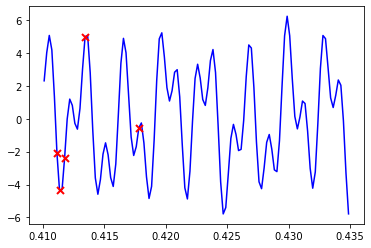

In [5]:
# Plot
time_interval_window = [0.41,0.435]
n1 = np.arange(n)[t>=time_interval_window[0]][0]
n2 = np.arange(n)[t>=time_interval_window[1]][0]

t_w = (y_t>=time_interval_window[0]) & \
      (y_t<=time_interval_window[1])

plt.plot(t[n1:n2],x[n1:n2],"b-")
plt.plot(y_t[t_w],y[t_w],"rx",markersize=7,markeredgewidth=2)
plt.show()

In [6]:
Psi = sp.fft.fft(np.eye(n,n))
Theta = Psi[perm,:]

s = cosamp(np.real(Theta),y,10,epsilon=1.e-10,max_iter=10)
xrecon = sp.fft.ifft(s) * n

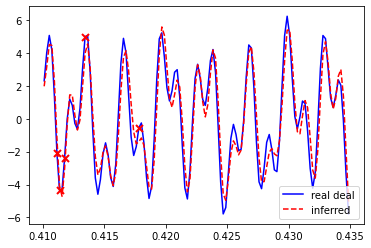

In [7]:
plt.plot(t[n1:n2],x[n1:n2],"b-")
plt.plot(t[n1:n2],np.real(xrecon[n1:n2]),"r--")
plt.plot(y_t[t_w],y[t_w],"rx",markersize=7,markeredgewidth=2)
plt.legend(["real deal","inferred"])
plt.show()

In [8]:
amps_recon = np.abs(s)
amps_recon_normd = amps_recon/np.max(amps_recon)
freqs_recon = np.arange(s.size)[amps_recon_normd>0.25]

# Remove the symmetrical frequencies
freqs_recon = freqs_recon[:int(freqs_recon.size/2)]
for freq in freqs_recon:
    print("{:3d} : {:.3f}".format(freq,amps_recon[freq]))


 95 : 0.467
300 : 1.562
677 : 1.118


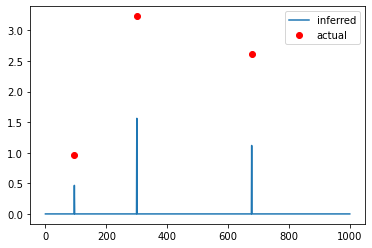

In [9]:
# Set the noise frequencies' amplitudes to 0
amps_recon[amps_recon_normd<0.25] = 0
freq_upto = 1000
plt.plot(np.arange(freq_upto),amps_recon[:freq_upto])
plt.plot(freqs,amps,"or")
plt.legend(["inferred","actual"])
plt.show()

The amplitudes are not quite yet there but they can be refined using the least squares fitting method:

In [10]:
C = np.empty((0,xrecon.size))
for f in freqs_recon:
    C = np.vstack([C,np.cos(two_pi_t*f)])
C = C.T
print(C)

[[ 1.          1.          1.        ]
 [ 0.9922747   0.92384821  0.63222431]
 [ 0.96921815  0.70699105 -0.20058483]
 ...
 [ 0.96921815  0.70699105 -0.20058483]
 [ 0.9922747   0.92384821  0.63222431]
 [ 1.          1.          1.        ]]


In [11]:
amps_fitted =  np.linalg.lstsq(C,xrecon,rcond=None)[0]
amps_fitted = np.real(amps_fitted)
print(("{:.3f} | "*amps_fitted.size).format(*amps_fitted))

0.928 | 3.042 | 1.955 | 


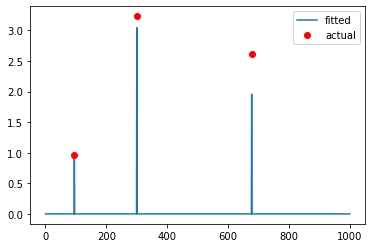

In [12]:
amps_fitted2 = np.zeros(xrecon.size)
for i in range(amps_fitted.size):
    amps_fitted2[freqs_recon[i]] = amps_fitted[i]
plt.plot(np.arange(freq_upto),amps_fitted2[:freq_upto])
plt.plot(freqs,amps,"or")
plt.legend(["fitted","actual"])
plt.show()

# References:
* [Data Driven Science & Engineering (Chp. 3.3), Steven L. Brunton & J. Nathan Kutz](http://www.databookuw.com/) ([Freely available as PDF](http://databookuw.com/databook.pdf))
* [Data Driven Science & Engineering Codes, Steven L. Brunton & J. Nathan Kutz](https://github.com/dynamicslab/databook_python)
* [Steven Brunton's YouTube Channel](https://www.youtube.com/channel/UCm5mt-A4w61lknZ9lCsZtBw)
  * [Beating Nyquist with Compressed Sensing](https://www.youtube.com/watch?v=A8W1I3mtjp8)
  * [Beating Nyquist with Compressed Sensing, in Python](https://www.youtube.com/watch?v=5-LY6wBIKx8)
  * [Beating Nyquist with Compressed Sensing, part 2](https://www.youtube.com/watch?v=HVR2DaaD0Xo)
  * [Compressed Sensing: Overview](https://www.youtube.com/watch?v=SbU1pahbbkc)
  * [Compressed Sensing: When It Works](https://www.youtube.com/watch?v=hmBTACBGWJs)
  * [Compressed Sensing: Mathematical Formulation](https://www.youtube.com/watch?v=inr-nGnVc0k)
* [Nathan Kutz' lecture on Compressive Sensing (February 2021)](https://www.youtube.com/watch?v=rt5mMEmZHfs)
* CoSaMP - _Compressive Sampling Matching Pursuit_ Algorithm
  * [D. Needell & J.A. Tropp's article](http://users.cms.caltech.edu/~jtropp/papers/NT08-CoSaMP-Iterative-preprint.pdf)
  * [Aladin Virmaux' implementation to Python](https://github.com/avirmaux/CoSaMP)